<a href="https://colab.research.google.com/github/Angi03/time_series/blob/main/4_Vector_Auto_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**VECTOR AUTO REGRESSION EQUATION:**

The dynamics of complex phenomena in economics and finance can rarely
be described using a single time series. That's why, we will turn to multidimensional time series, but it should always be
borne in mind that many time series change synchronously in a certain interdependence. Therefore, now we will move on to approaches
and methods of joint modeling of two or more time series.

Vector autoregression (VAR) is a model of the dynamics of several time series in which the current values of these series depend on the past values of the same time series. The model is proposed by Christopher Sims as an alternative to systems of simultaneous equations that assume significant theoretical limitations. VAR models are free from the constraints of structural models. Nevertheless, the problem of VAR models is a sharp increase in the number of parameters with an increase in the number of analyzed time series and the number of lags.

The simplest example is a two-dimensional vector autoregressive model

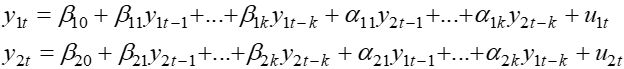

where uit are independent and equally distributed error terms with E(uit)=0, i=1,2; E(u1t u2t)=0.

The analysis can be extended to the VAR(g) model or so that there are g variables and g equations.

In [22]:
#Importing Libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [23]:
from datetime import datetime
import yfinance as yf

**Parsing from yahoo finance**

In [24]:
tickers_list = ['GC=F', 'SI=F', 'CL=F']
yf.download(tickers_list)
data = pd.DataFrame(columns = tickers_list)
for ticker in tickers_list:
    data[ticker] = yf.download(ticker, start = '2007-01-01')['Close']
data

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,GC=F,SI=F,CL=F
Date,,,
2007-01-02,635.200012,12.818000,61.049999
2007-01-03,627.099976,12.555000,58.320000
2007-01-04,623.900024,12.727000,55.590000
2007-01-05,604.900024,12.130000,56.310001
2007-01-08,607.500000,12.260000,56.090000
...,...,...,...
2025-04-04,3012.000000,29.115999,61.990002
2025-04-07,2951.300049,29.510000,60.700001
2025-04-08,2968.399902,29.591999,59.580002


In [25]:
data.isnull().sum() #missing values

,0
GC=F,0
SI=F,0
CL=F,0


In [26]:
data=data.fillna(method='pad') #filling the missing values with previous one
data.isnull().sum()

,0
GC=F,0
SI=F,0
CL=F,0


In [27]:
data

,GC=F,SI=F,CL=F
Date,,,
2007-01-02,635.200012,12.818000,61.049999
2007-01-03,627.099976,12.555000,58.320000
2007-01-04,623.900024,12.727000,55.590000
2007-01-05,604.900024,12.130000,56.310001
2007-01-08,607.500000,12.260000,56.090000
...,...,...,...
2025-04-04,3012.000000,29.115999,61.990002
2025-04-07,2951.300049,29.510000,60.700001
2025-04-08,2968.399902,29.591999,59.580002


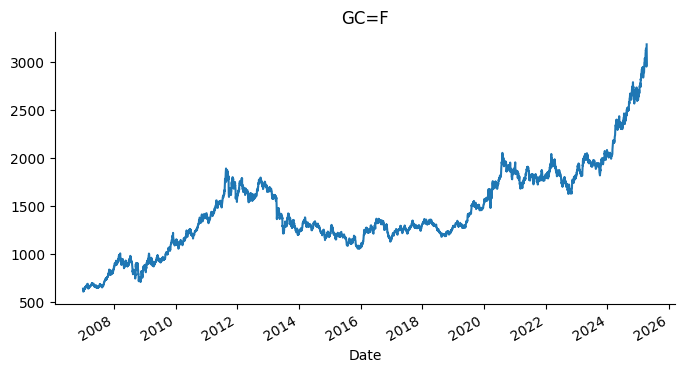

In [28]:
# @title GC=F

from matplotlib import pyplot as plt
data['GC=F'].plot(kind='line', figsize=(8, 4), title='GC=F')
plt.gca().spines[['top', 'right']].set_visible(False)

The NaN values in the data are filled with previous days data. After doing some necessary pre-processing, the dataset now clean for further analysis.

**Plot of historical data**

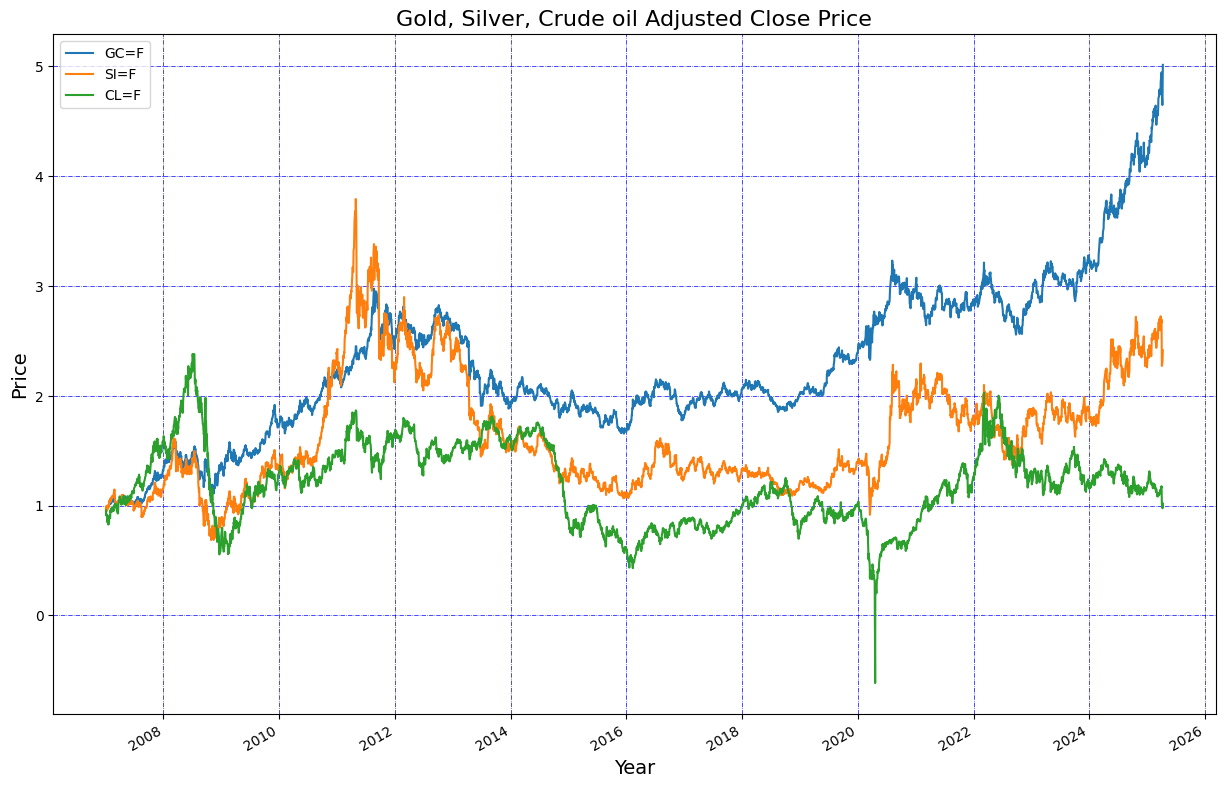

In [29]:
# Plot all the close prices
((data.pct_change()+1).cumprod()).plot(figsize=(15, 10))
# Show the legend
plt.legend()
# Define the label for the title of the figure
plt.title("Gold, Silver, Crude oil Adjusted Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='b', linestyle='-.', linewidth=0.5)
#plt.savefig('Green_Adj_Close_Price.png')
plt.show()

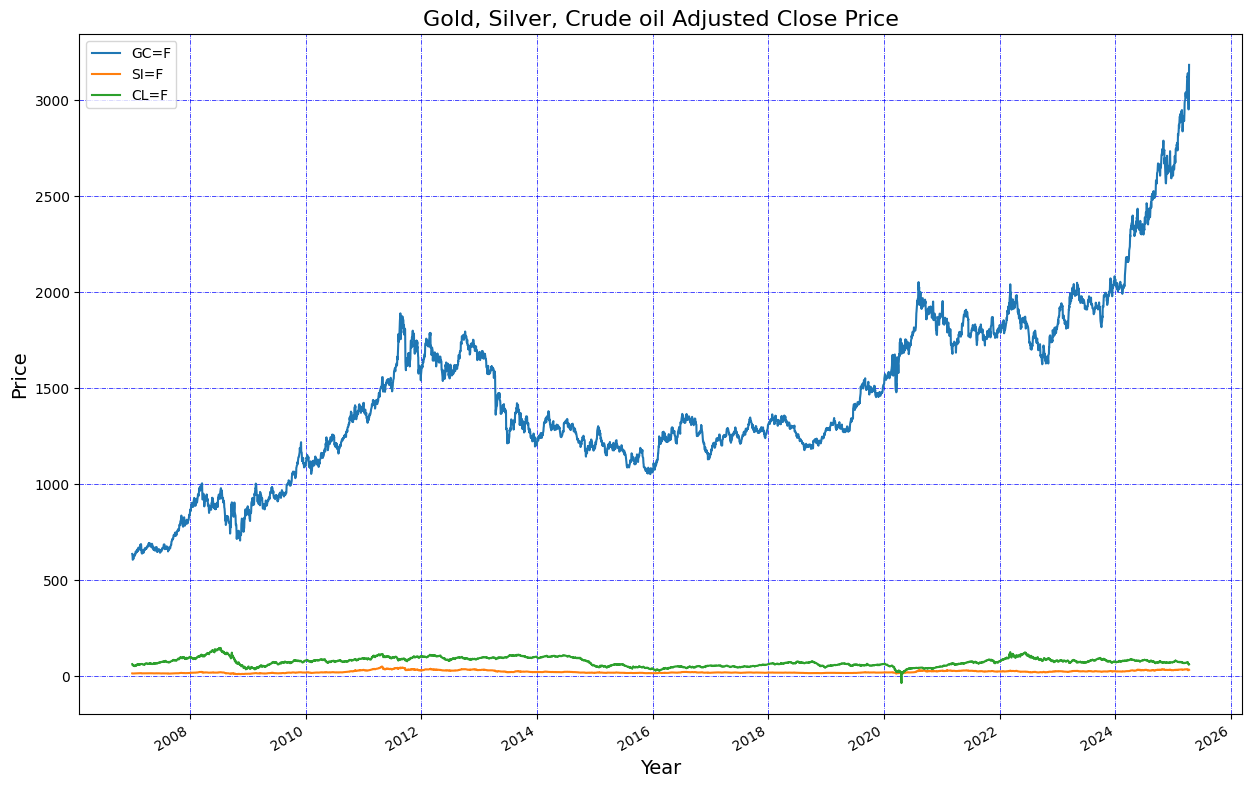

In [30]:
# Plot all the close prices
data.plot(figsize=(15, 10))
# Show the legend
plt.legend()
# Define the label for the title of the figure
plt.title("Gold, Silver, Crude oil Adjusted Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='b', linestyle='-.', linewidth=0.5)
#plt.savefig('Green_Adj_Close_Price.png')
plt.show()

**Converting data to log return**

In [31]:
log_returns = np.log(data)-np.log(data.shift(1))
log_returns = log_returns.round(3)
log_returns = log_returns.dropna()

In [32]:
log_returns

,GC=F,SI=F,CL=F
Date,,,
2007-01-03,-0.013,-0.021,-0.046
2007-01-04,-0.005,0.014,-0.048
2007-01-05,-0.031,-0.048,0.013
2007-01-08,0.004,0.011,-0.004
2007-01-09,0.009,0.019,-0.008
...,...,...,...
2025-04-04,-0.028,-0.090,-0.077
2025-04-07,-0.020,0.013,-0.021
2025-04-08,0.006,0.003,-0.019


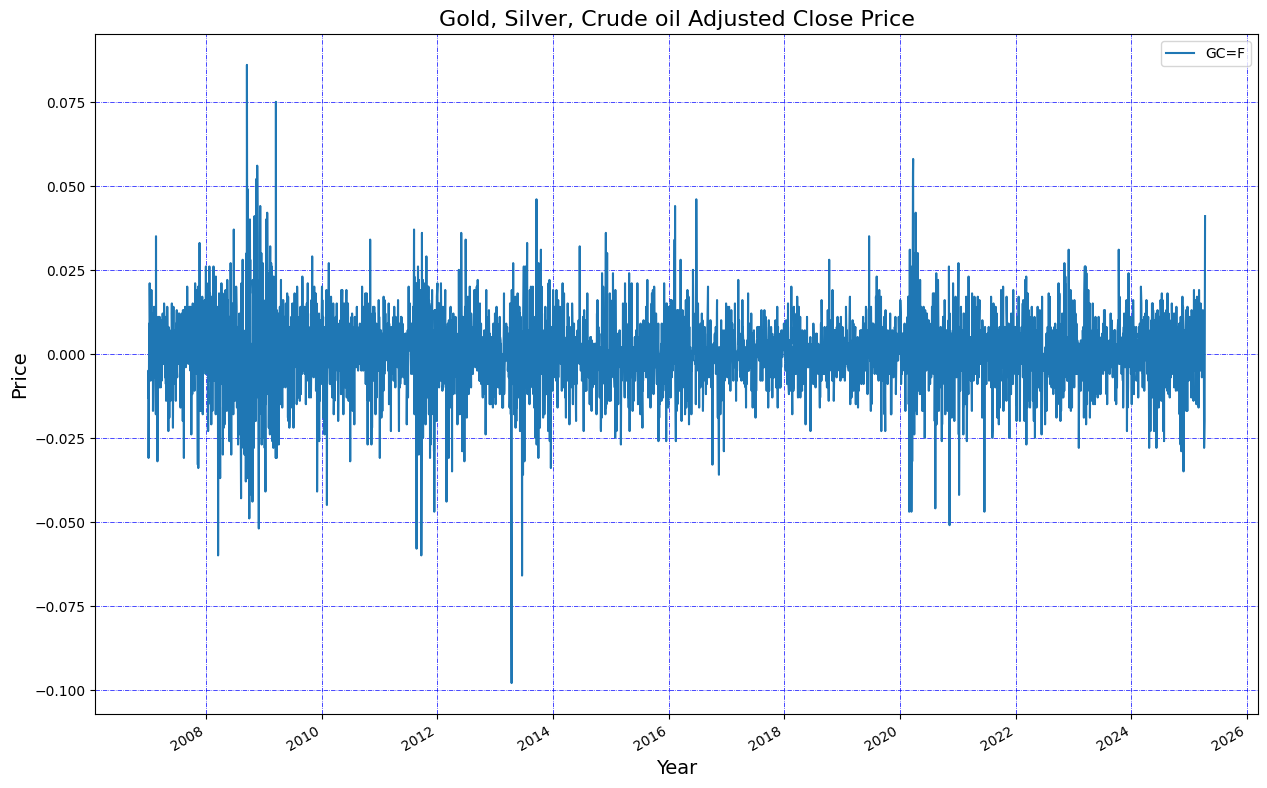

In [33]:
# Plot all the close prices
log_returns['GC=F'].plot(figsize=(15, 10))
# Show the legend
plt.legend()
# Define the label for the title of the figure
plt.title("Gold, Silver, Crude oil Adjusted Close Price", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
# Plot the grid lines
plt.grid(which="major", color='b', linestyle='-.', linewidth=0.5)
#plt.savefig('Green_Adj_Close_Price.png')
plt.show()

In [34]:
log_returns.isnull().sum()

,0
GC=F,0
SI=F,0
CL=F,0


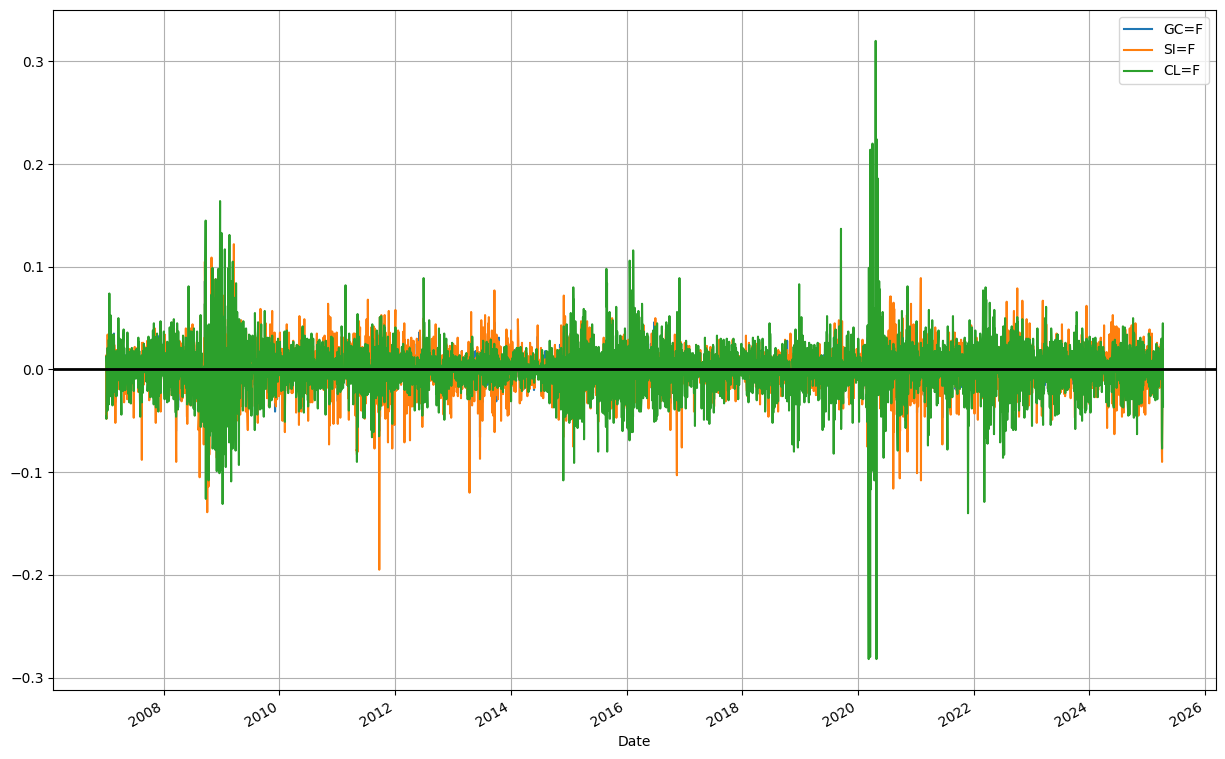

In [35]:
log_returns.plot(grid = True, figsize = (15,10)).axhline(y = 0, color = "black", lw = 2)

**Augmented Dickey-Fuller Test**

A time series is said to be “stationary” if it has no trend, exhibits constant variance over time, and has a constant autocorrelation structure over time.

One way to test whether a time series is stationary is to perform an augmented Dickey-Fuller test, which uses the following null and alternative hypotheses:

H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

HA: The time series is stationary.

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [36]:
ad_fuller_result_1 = adfuller(log_returns['GC=F'])

print('Gold')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(log_returns['SI=F'])

print('Silver')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(log_returns['CL=F'])

print('Crude Oil')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

Gold
ADF Statistic: -21.49485689054838
p-value: 0.0

---------------------

Silver
ADF Statistic: -22.653561247794897
p-value: 0.0

---------------------

Crude Oil
ADF Statistic: -11.8843573323338
p-value: 6.072657096920579e-22


A difference transform is a simple way for removing a systematic structure from the time series. We will remove trend by subtracting the previous value from each value in the series which is the first order differencing. To keep it simple, we will do first order differencing or seasonal differencing.

In [37]:
ad_fuller_result_1 = adfuller(data['GC=F'].diff(1).dropna())

print('Gold')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(data['SI=F'].diff(1).dropna())

print('Silver')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(data['CL=F'].diff(1).dropna())

print('Crude Oil')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

Gold
ADF Statistic: -20.91782637679682
p-value: 0.0

---------------------

Silver
ADF Statistic: -13.232206963712402
p-value: 9.534379769676843e-25

---------------------

Crude Oil
ADF Statistic: -10.968143039136514
p-value: 8.005931842260459e-20


**Granger Causality test**

The Granger Causality test is used to determine whether or not one time series is useful for forecasting another.

This test uses the following null and alternative hypotheses:

Null Hypothesis (H0): Time series x does not Granger-cause time series y

Alternative Hypothesis (HA): Time series x Granger-causes time series y

The term “Granger-causes” means that knowing the value of time series x at a certain lag is useful for predicting the value of time series y at a later time period.

This test produces an F test statistic with a corresponding p-value. If the p-value is less than a certain significance level (i.e. α = .05), then we can reject the null hypothesis and conclude that we have sufficient evidence to say that time series x Granger-causes time series y.

In [38]:
print('gold causes crude oil?\n')
print('------------------')
granger_1 = grangercausalitytests(log_returns[['GC=F', 'CL=F']], 4)

print('\ncrude oil causes gold?\n')
print('------------------')
granger_2 = grangercausalitytests(log_returns[['CL=F', 'GC=F']], 4)

gold causes crude oil?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4567  , p=0.2275  , df_denom=4590, df_num=1
ssr based chi2 test:   chi2=1.4577  , p=0.2273  , df=1
likelihood ratio test: chi2=1.4575  , p=0.2273  , df=1
parameter F test:         F=1.4567  , p=0.2275  , df_denom=4590, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0277  , p=0.3579  , df_denom=4587, df_num=2
ssr based chi2 test:   chi2=2.0576  , p=0.3574  , df=2
likelihood ratio test: chi2=2.0571  , p=0.3575  , df=2
parameter F test:         F=1.0277  , p=0.3579  , df_denom=4587, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8615  , p=0.4603  , df_denom=4584, df_num=3
ssr based chi2 test:   chi2=2.5883  , p=0.4595  , df=3
likelihood ratio test: chi2=2.5876  , p=0.4597  , df=3
parameter F test:         F=0.8615  , p=0.4603  , df_denom=4584, df_num=3

Granger Causality
number of lags (no zero) 4

In [39]:
print('gold causes crude oil?\n')
print('------------------')
granger_1 = grangercausalitytests(log_returns[['GC=F', 'CL=F']], 4)

print('\ncrude oil causes gold?\n')
print('------------------')
granger_2 = grangercausalitytests(log_returns[['CL=F', 'GC=F']], 4)

gold causes crude oil?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4567  , p=0.2275  , df_denom=4590, df_num=1
ssr based chi2 test:   chi2=1.4577  , p=0.2273  , df=1
likelihood ratio test: chi2=1.4575  , p=0.2273  , df=1
parameter F test:         F=1.4567  , p=0.2275  , df_denom=4590, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0277  , p=0.3579  , df_denom=4587, df_num=2
ssr based chi2 test:   chi2=2.0576  , p=0.3574  , df=2
likelihood ratio test: chi2=2.0571  , p=0.3575  , df=2
parameter F test:         F=1.0277  , p=0.3579  , df_denom=4587, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8615  , p=0.4603  , df_denom=4584, df_num=3
ssr based chi2 test:   chi2=2.5883  , p=0.4595  , df=3
likelihood ratio test: chi2=2.5876  , p=0.4597  , df=3
parameter F test:         F=0.8615  , p=0.4603  , df_denom=4584, df_num=3

Granger Causality
number of lags (no zero) 4

In [40]:
data

,GC=F,SI=F,CL=F
Date,,,
2007-01-02,635.200012,12.818000,61.049999
2007-01-03,627.099976,12.555000,58.320000
2007-01-04,623.900024,12.727000,55.590000
2007-01-05,604.900024,12.130000,56.310001
2007-01-08,607.500000,12.260000,56.090000
...,...,...,...
2025-04-04,3012.000000,29.115999,61.990002
2025-04-07,2951.300049,29.510000,60.700001
2025-04-08,2968.399902,29.591999,59.580002


In [41]:
#Splitting the dataset
train_df=data[:-1200]
test_df=data[-1200:]

print(train_df.shape)
print(test_df.shape)

(3397, 3)
(1200, 3)


In [42]:
model = VAR(train_df.diff()[1:])

In [43]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.279       4.284       72.15       4.281
1        4.226      4.248*       68.44       4.234
2        4.217       4.255       67.83      4.231*
3        4.220       4.274       68.01       4.239
4        4.217       4.288       67.84       4.242
5        4.219       4.306       67.98       4.250
6        4.217       4.321       67.86       4.254
7        4.215       4.335       67.71       4.258
8        4.216       4.352       67.79       4.265
9        4.212       4.364       67.47       4.266
10       4.212       4.380       67.47       4.272
11       4.213       4.398       67.59       4.280
12       4.213       4.414       67.53       4.285
13       4.209       4.427       67.31       4.287
14       4.210       4.444       67.34       4.293
15       4.208       4.459       67.24       4.298
16       4.202       4.469     

In [44]:
print(model.select_order(20))

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 18, BIC -> 1, FPE -> 18, HQIC ->  2>


In [45]:
results = model.fit(16)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Apr, 2025
Time:                     15:59:40
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    4.46611
Nobs:                     3380.00    HQIC:                   4.29495
Log likelihood:          -21338.5    FPE:                    66.6669
AIC:                      4.19970    Det(Omega_mle):         63.8495
--------------------------------------------------------------------
Results for equation GC=F
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.365111         0.246361            1.482           0.138
L1.GC=F         -0.025540         0.026724           -0.956           0.339
L1.SI=F          0.765354         0.854778            0.895           0.371
L1.CL

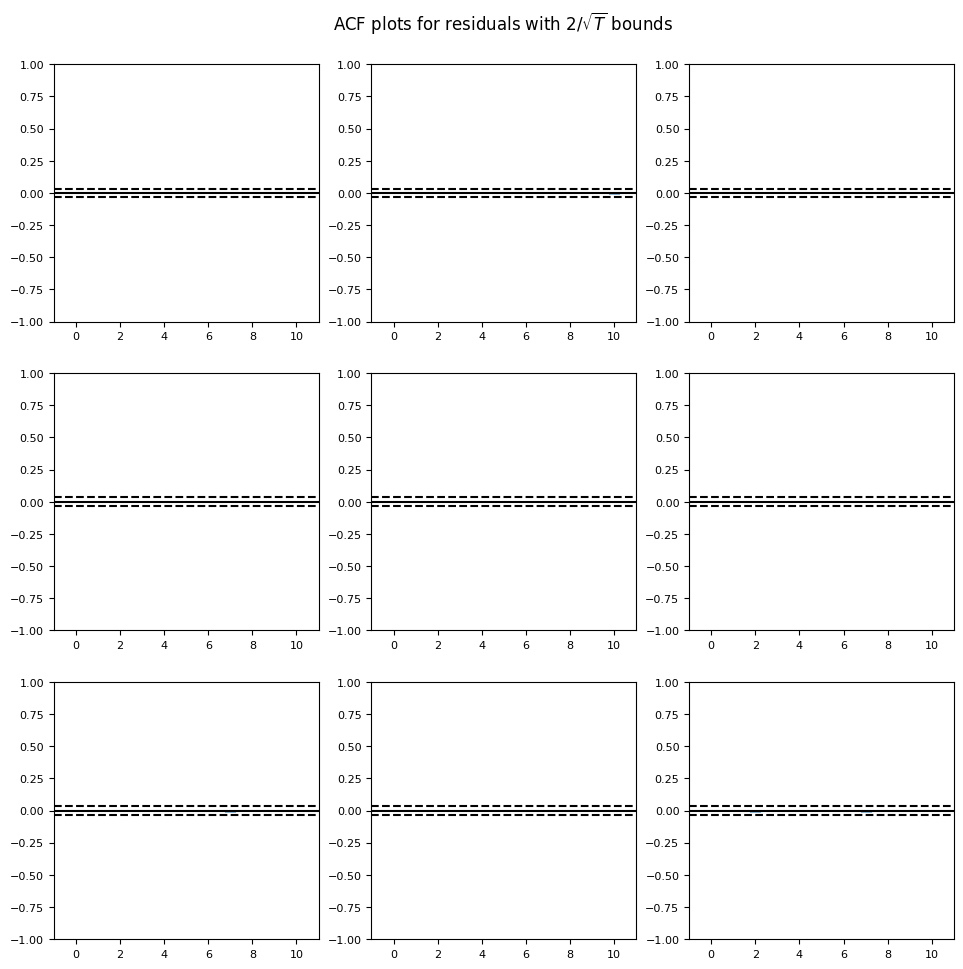

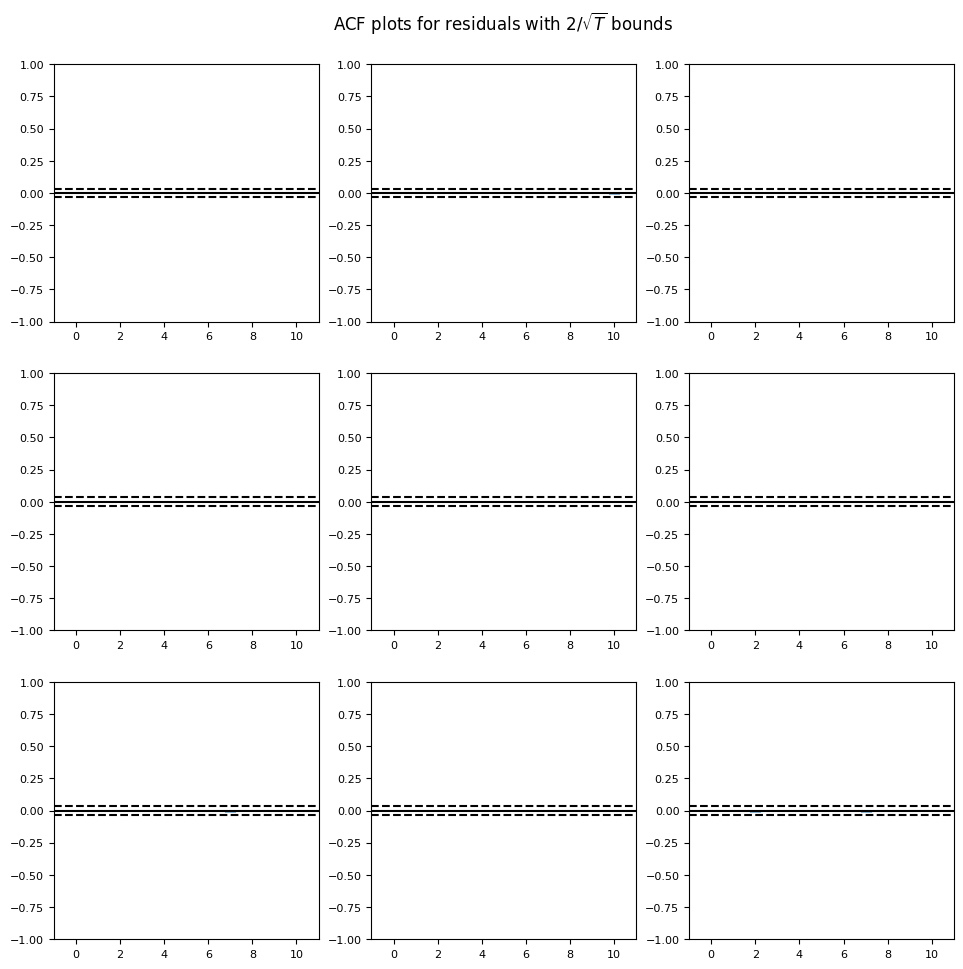

In [46]:
results.plot_acorr()

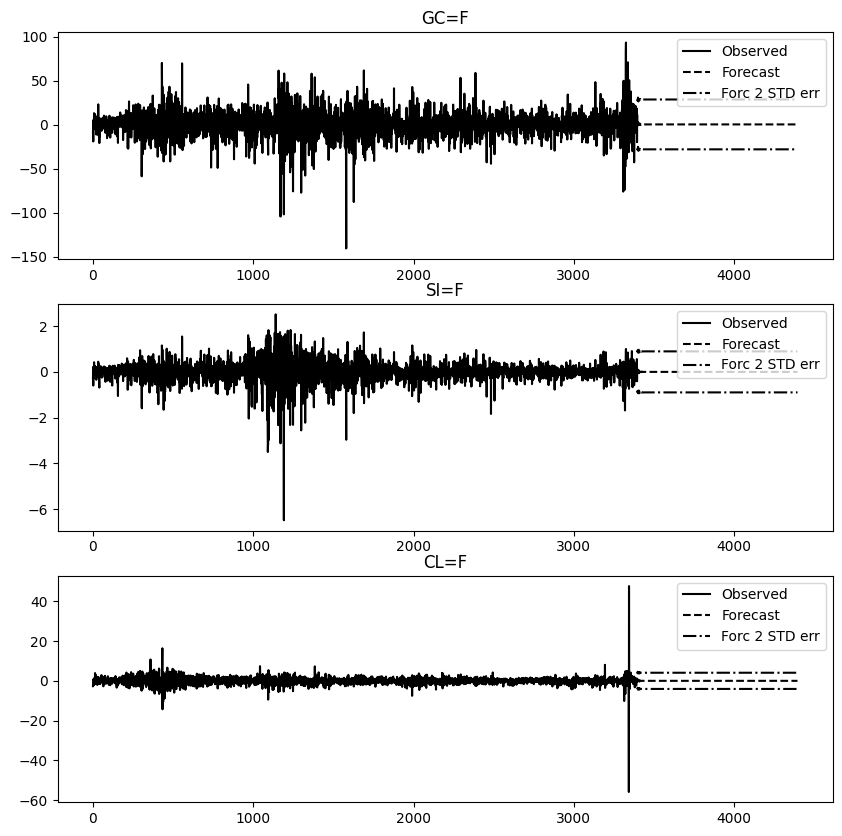

In [47]:
results.plot_forecast(1000)
plt.show()

# **Impulse Response Function**

An impulse response can be defined as the reaction of a system, in response to an external change. In the macroeconomic context, the system is a system of equations that comprise a multivariate autoregressive model, and the external change is referred to as an exogenous shock. All the variables in a VAR model depend on each other; therefore, individual coefficient estimates provide limited information on the reaction of the system to a shock. Hence, the need for impulse responses, which provide information about the dynamic behaviour of a VAR model. Subsequently, the purpose of an impulse response function (IRF) is to describe the evolution of a VAR model’s reaction to a shock in one or more variables. In other words, an IRF allows us to trace the transmission of a single shock within a system of equations, a feature which makes them useful for evaluating economic policy.




In [48]:
irf = results.irf(10)

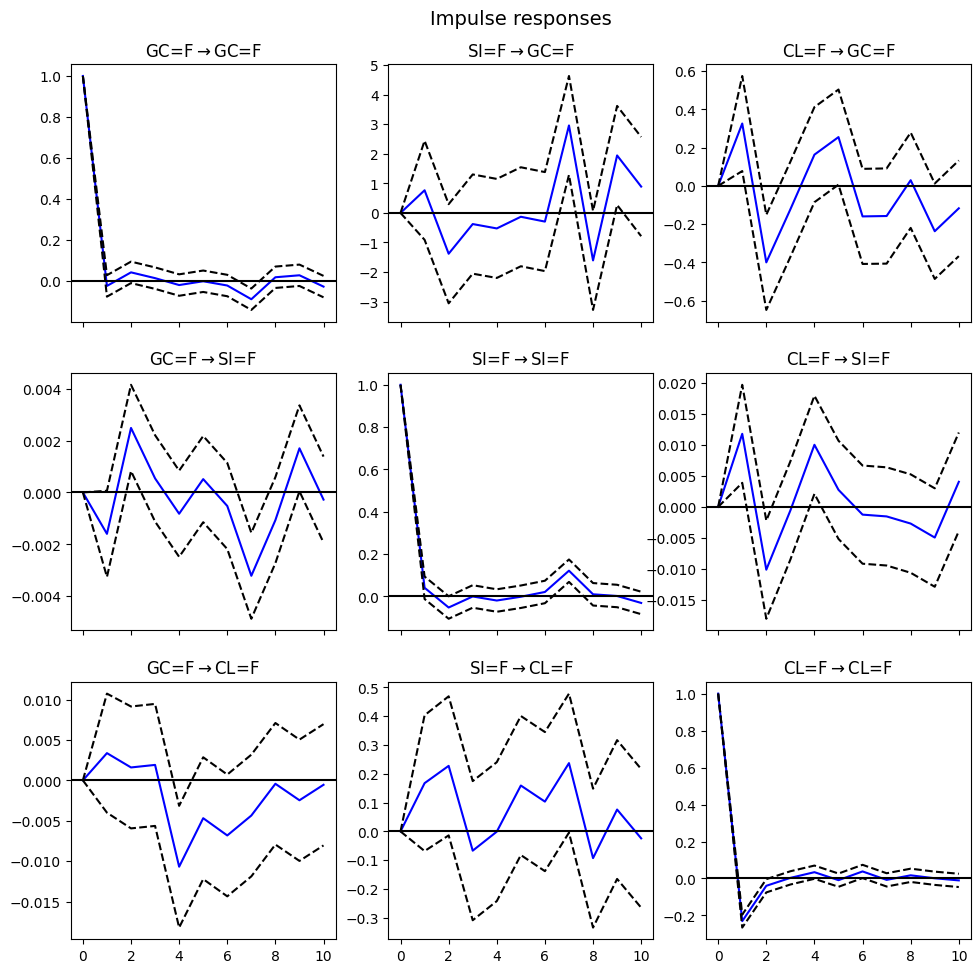

In [49]:
irf.plot(orth=False)
plt.show()

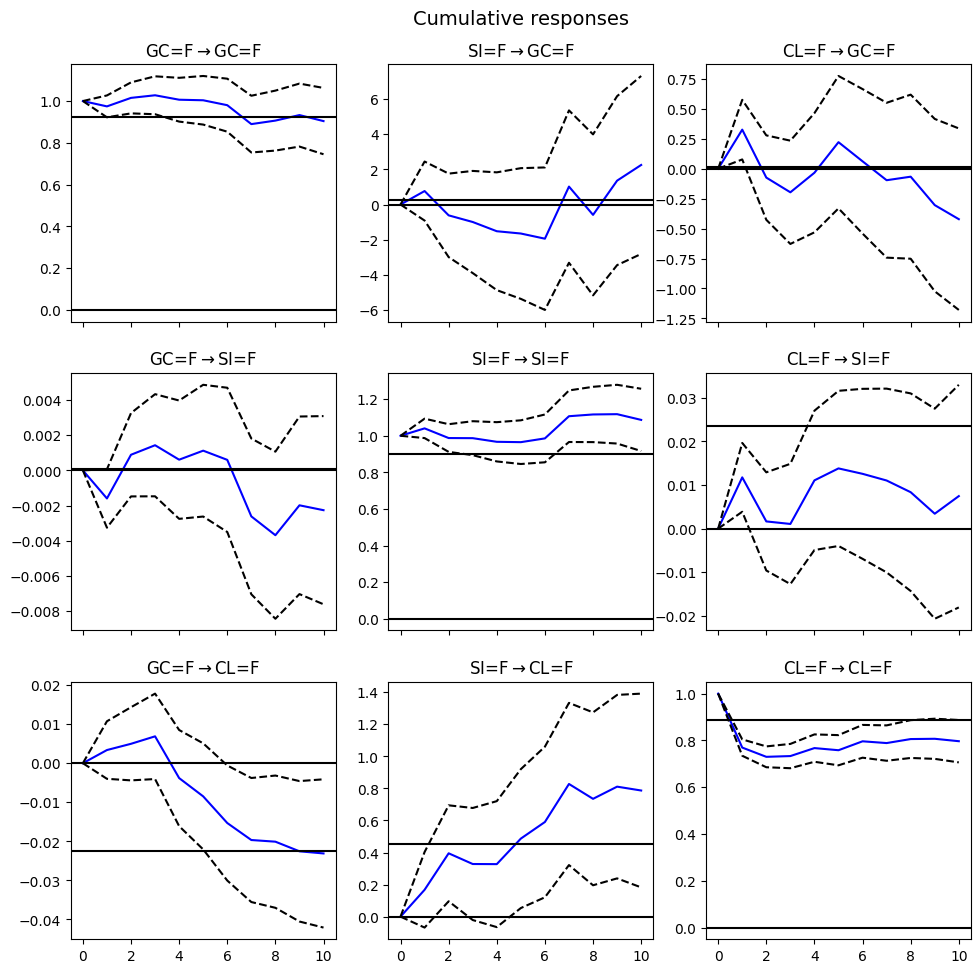

In [50]:
irf.plot_cum_effects(orth=False)
plt.show()

In [51]:
print(results.test_normality())

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 6670733.591, critical value: 12.592>, p-value: 0.000>


In [52]:
#Splitting the log dataset with difference
ldtrain_df=log_returns[:-12]
ldtest_df=log_returns[-12:]

print(ldtrain_df.shape)
print(ldtest_df.shape)

(4582, 3)
(12, 3)


In [53]:
ldmodel = VAR(ldtrain_df)


In [54]:
sorted_order=ldmodel.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -25.12     -25.12*   1.229e-11     -25.12*
1       -25.12      -25.11   1.226e-11      -25.12
2       -25.13      -25.10   1.219e-11      -25.12
3       -25.13      -25.09   1.219e-11      -25.12
4       -25.13      -25.08   1.217e-11      -25.11
5       -25.13      -25.06   1.219e-11      -25.11
6       -25.13      -25.05   1.217e-11      -25.10
7       -25.13      -25.04   1.215e-11      -25.10
8       -25.13      -25.03   1.215e-11      -25.10
9       -25.13      -25.01   1.216e-11      -25.09
10      -25.13      -25.00   1.218e-11      -25.08
11      -25.13      -24.99   1.218e-11      -25.08
12      -25.13      -24.98   1.216e-11      -25.08
13      -25.13      -24.96   1.217e-11      -25.07
14      -25.14      -24.95   1.213e-11      -25.07
15      -25.13      -24.94   1.214e-11      -25.07
16      -25.14      -24.93   1.

**Macroeconomic data modelling**

In [55]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
macro_data = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(macro_data.shape)  # (123, 8)
macro_data.head()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8


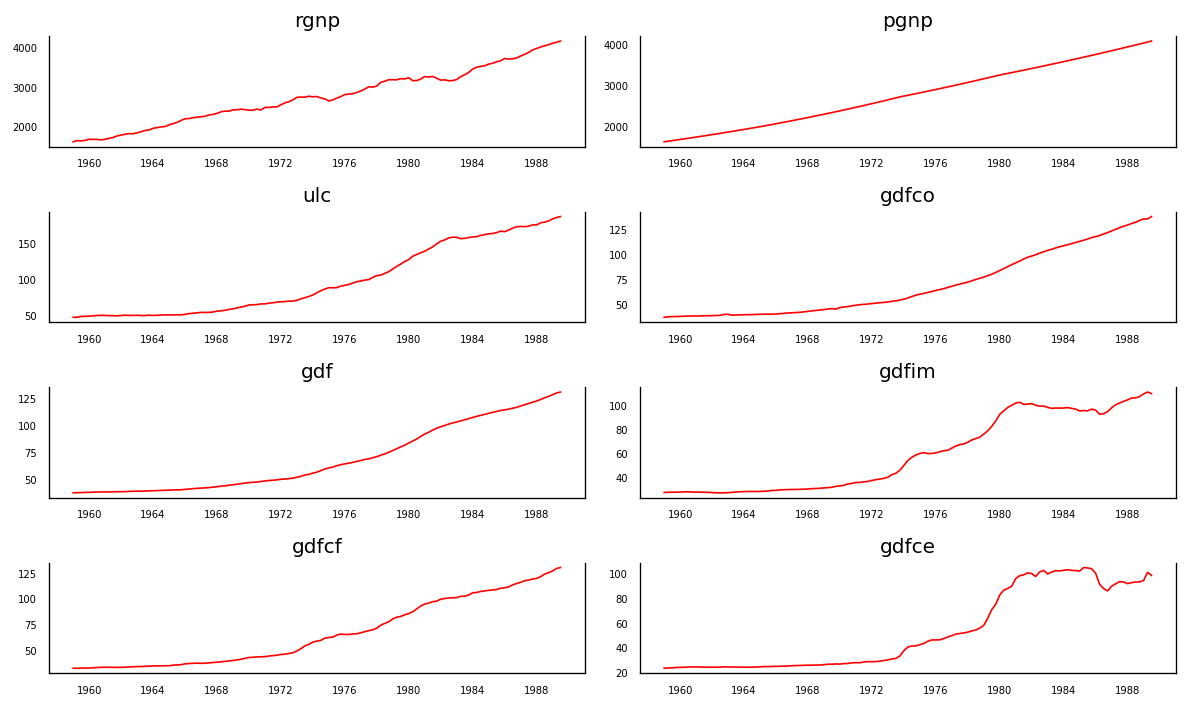

In [56]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

1. rgnp : Real GNP.
2. pgnp : Potential real GNP.
3. ulc : Unit labor cost.
4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
5. gdf : Fixed weight GNP deflator.
6. gdfim : Fixed weight import deflator.
7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.
8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.

In [57]:
ad_fuller_result_1 = adfuller(macro_data['rgnp'].diff()[1:]) #what will it be if we omit the difference?

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['ulc'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')


realgdp
ADF Statistic: -5.427594381007333
p-value: 2.9633019848469254e-06

---------------------

realcons
ADF Statistic: -3.576080473150911
p-value: 0.006235131830238172


In [58]:
print('rgnp causes ulc?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_data[['ulc', 'rgnp']], 4)

print('\nulc causes rgnp?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_data[['rgnp', 'ulc']], 4)


rgnp causes ulc?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.3802 , p=0.0000  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=22.9444 , p=0.0000  , df=1
likelihood ratio test: chi2=21.0242 , p=0.0000  , df=1
parameter F test:         F=22.3802 , p=0.0000  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7188  , p=0.0007  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=16.1029 , p=0.0003  , df=2
likelihood ratio test: chi2=15.1179 , p=0.0005  , df=2
parameter F test:         F=7.7188  , p=0.0007  , df_denom=116, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5231  , p=0.0001  , df_denom=113, df_num=3
ssr based chi2 test:   chi2=23.9675 , p=0.0000  , df=3
likelihood ratio test: chi2=21.8515 , p=0.0001  , df=3
parameter F test:         F=7.5231  , p=0.0001  , df_denom=113, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F

In [59]:
macro_data = macro_data[['ulc','rgnp']]
print(macro_data.shape)

(123, 2)


In [60]:
train_df=macro_data[:-12]
test_df=macro_data[-12:]

In [61]:
print(test_df.shape)

(12, 2)


In [62]:
model_m = VAR(train_df.diff()[1:])

In [63]:
sorted_order=model_m.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        6.778       6.834       878.3       6.800
1        5.988      6.154*       398.5       6.055
2        5.942       6.220       380.9       6.054
3        5.933       6.322       377.4       6.090
4       5.793*       6.293      328.5*      5.995*
5        5.873       6.484       356.3       6.120
6        5.828       6.550       341.1       6.119
7        5.894       6.727       365.0       6.230
8        5.890       6.835       364.8       6.271
9        5.942       6.998       385.8       6.368
10       5.930       7.097       382.9       6.401
11       5.913       7.191       378.5       6.428
12       5.885       7.274       370.7       6.445
13       5.925       7.424       388.6       6.529
14       5.882       7.493       376.0       6.532
15       5.950       7.672       406.9       6.644
16       5.933       7.766     

In [64]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                           Statespace Model Results                           
Dep. Variable:        ['ulc', 'rgnp']   No. Observations:                  111
Model:                         VAR(4)   Log Likelihood              -11921.099
                          + intercept   AIC                          23884.199
Date:                Thu, 10 Apr 2025   BIC                          23941.099
Time:                        15:59:51   HQIC                         23907.281
Sample:                    01-01-1959                                         
                         - 07-01-1986                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):          31.87, 106.12   Jarque-Bera (JB):         35.34, 13.90
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.15, 0.28   Skew:                      0.87, -0.86
Prob(H) (two-sided):            0.67,

Although VAR models are also used in the field of machine learning, the primary usage is for forecasting.

In [65]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [66]:
predictions.columns=['ulc_predicted','rgnp_predicted']
predictions

,ulc_predicted,rgnp_predicted
1986-10-01,165.564535,3559.177461
1987-01-01,248.418487,3756.122324
1987-04-01,43.628907,3545.833958
1987-07-01,272.489880,3868.327199
1987-10-01,144.936262,3463.983473
1988-01-01,175.023548,3773.322539
1988-04-01,149.785231,3619.629606
1988-07-01,212.615794,3737.268347
1988-10-01,141.111073,3552.072964
1989-01-01,199.736244,3771.625288


In [67]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<Axes: >

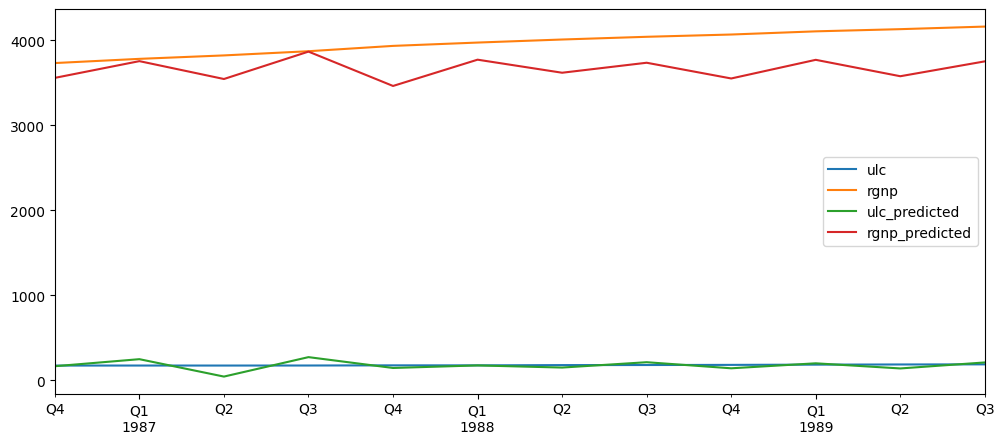

In [68]:
test_vs_pred.plot(figsize=(12,5))

In [69]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

rmse_ulc=math.sqrt(mean_squared_error(predictions['ulc_predicted'],test_df['ulc']))
print('Mean value of ULC is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['ulc']),rmse_ulc))

rmse_rgnp=math.sqrt(mean_squared_error(predictions['rgnp_predicted'],test_df['rgnp']))
print('Mean value of RGNP is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['rgnp']),rmse_rgnp))

Mean value of ULC is : 178.56666666666666. Root Mean Squared Error is :57.48114196093284
Mean value of RGNP is : 3970.6916666666666. Root Mean Squared Error is :350.2308674260732


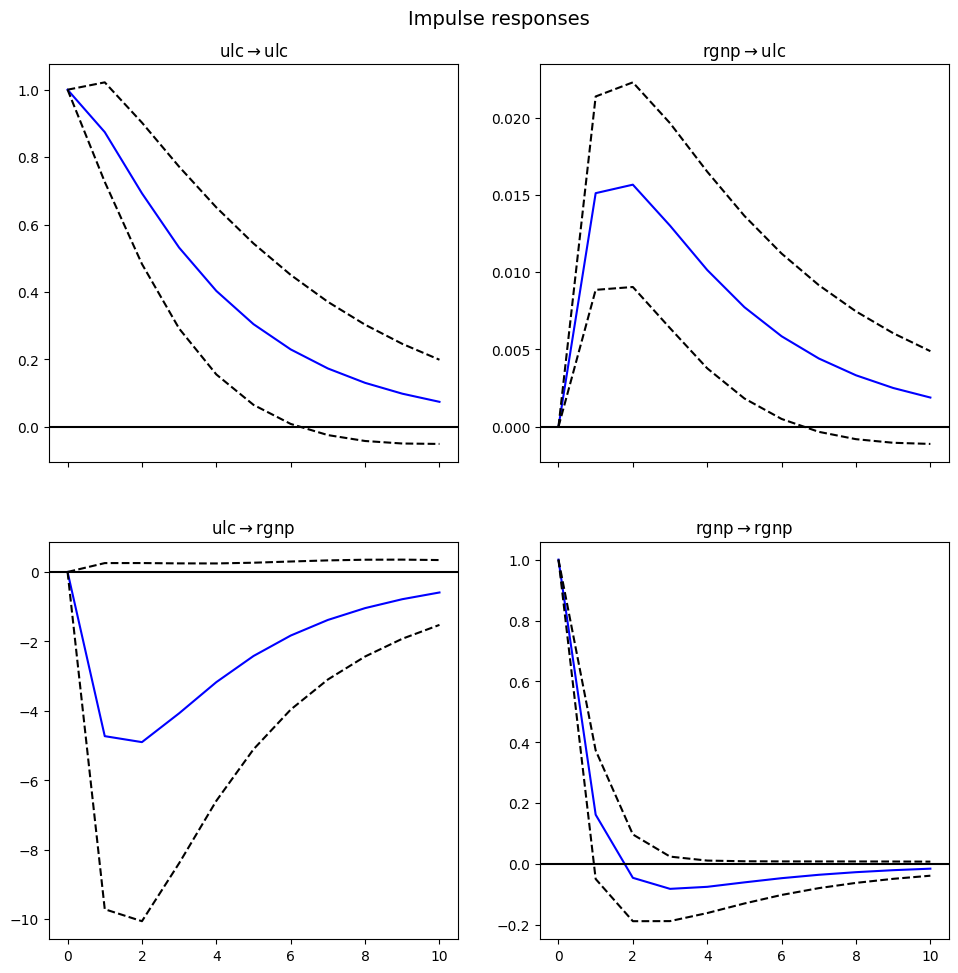

In [70]:
model_macro = model_m.fit(maxlags=15, ic='bic')
irf = model_macro.irf(10)
irf.plot(orth=False)
plt.show()

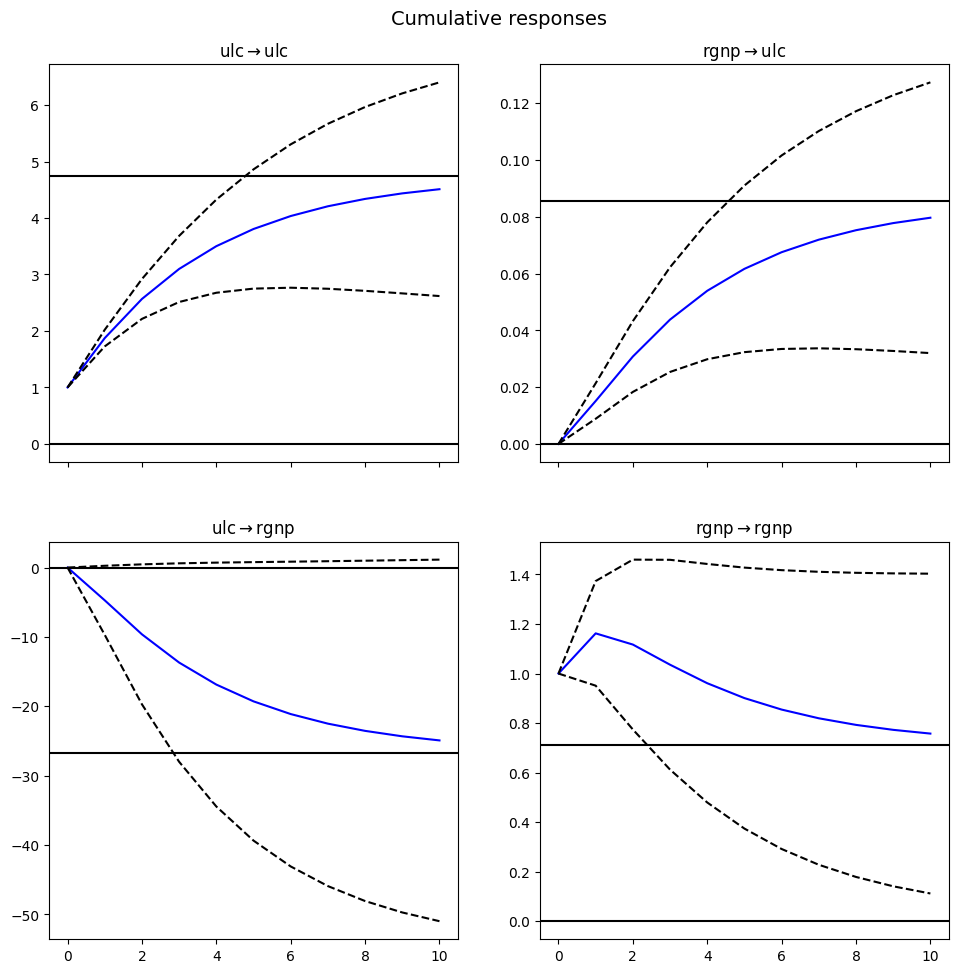

In [71]:
irf.plot_cum_effects(orth=False)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

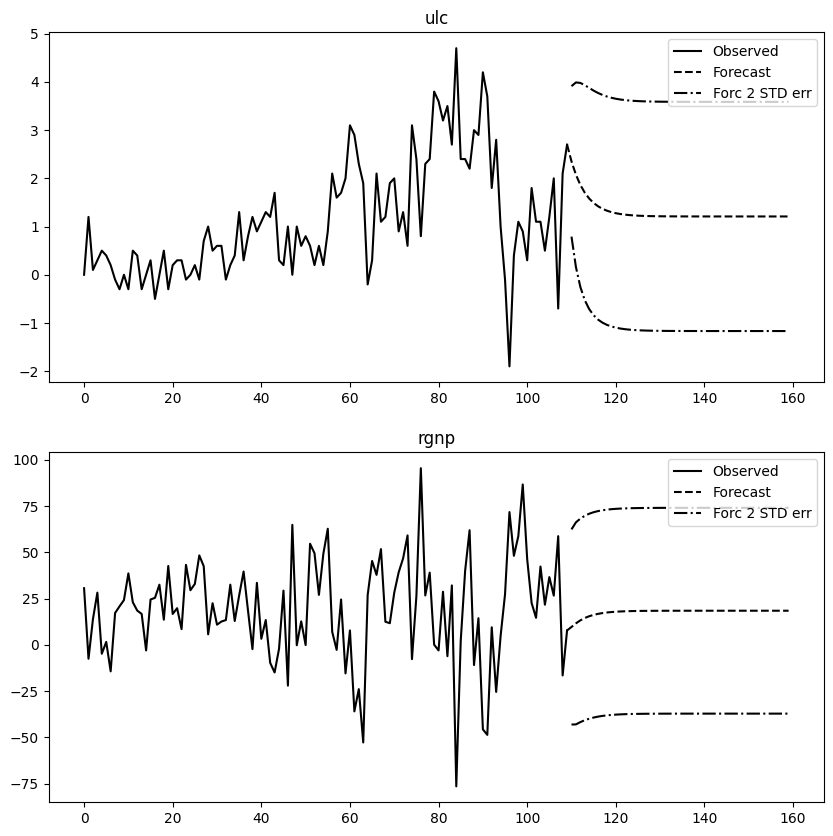

In [72]:
model_macro.plot_forecast(50)
plt.show